In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plot_format = {
    0  : ['mediumseagreen', '-'],
    1  : ['blue', ':'],
    2  : ['green', '-.'],
    3  : ['black', '--'],
    4  : ['hotpink', '-'],
    5  : ['orange', ':'],
    6  : ['brown', '-.'],
    7  : ['purple', '--'],
    8  : ['aquamarine', '-'],
    9  : ['red', ':'],
    10 : ['lawngreen', '-.'],
    11 : ['burlywood', '--'],
    12 : ['cadetblue', '-'],
    13 : ['darkgreen', ':'],
    14 : ['coral', '-.'],
    15 : ['cyan', '--'],
}

def find_pixel(initial_threshold_values):
    all_rising_edges = np.zeros((324,324), dtype=int)
    cols = initial_threshold_values.shape[1]
    rows = initial_threshold_values.shape[2]
    for c in range(cols):
        for r in range(rows):
            rising_edge = np.where(np.diff(initial_threshold_values[:,c,r] > 50))[0]
            if len(rising_edge) != 0: 
                all_rising_edges[c,r] = rising_edge[0]
    return all_rising_edges

# Define the Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2)

In [5]:
def static_trim(directory):
    files = [x for x in os.listdir(directory)]
    initial_threshold_values = []
    x = []
    for i, opf in enumerate(files):
        name = opf.split('_')
        x.append(int(name[0][1:]) - int(name[1][1:]))
        data = np.loadtxt(f'{directory}/{opf}', delimiter=',', dtype=np.uint8, converters=float, comments='#')
        initial_threshold_values.append(data)
    x = np.array(x)
    initial_threshold_values = np.array(initial_threshold_values)
    # Create an array for storing the counts of x value
    counts = np.zeros((x.shape))
    rising_edge_indices = find_pixel(initial_threshold_values)
    # Get the values of each rising edge and the counts
    values, unique_counts = np.unique(rising_edge_indices,return_counts=True)
    # Set the counts for each x value, some values do not appear so we cant just use the unique results
    counts[values] = unique_counts

    # Fit the data to the Gaussian function
    popt, pcov = curve_fit(gaussian, x, counts, p0=[max(counts), np.mean(x), np.std(x)])

    # Extract the optimized parameters
    amplitude, mean, stddev = popt

    # Generate the fitted curve
    x_fit = np.linspace(min(x), max(x), 1000)
    y_fit = gaussian(x_fit, *popt)

    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    axs[0].plot(x , initial_threshold_values[:,0,0], 'b+:')
    axs[0].set(xlabel='Voltage Threshold (mV)', ylabel='Digital Signal', title='Pixel : 0,0')
    axs[1].plot(x, counts,'b+:',label='Data')
    axs[1].plot(x_fit, y_fit, 'r', label=f'Mean : {mean:.2f} Std Dev : {stddev:.2f}', alpha=0.5)
    axs[1].plot(mean, amplitude, 'ro')
    axs[1].plot([mean - stddev, mean + stddev], [amplitude * 0.4, amplitude * 0.4], 'r:')
    axs[1].legend()
    axs[1].set(xlabel='Voltage Threshold (mV)', ylabel='Pixel Population', title='Mean Rising Edge Fit')

    plt.show()

In [2]:
def best_trim_value(directory, mean):
    files = [x for x in os.listdir(directory) if '.csv' in x]
    x = []
    trim_values = {x : [] for x in range(16)}
    pixel_means = []
    pixel_means_trims = []
    for i, opf in enumerate(files):
        name = opf.split('_')
        x.append(int(name[0][1:]) - int(name[1][1:]))
        # Load the array data
        data = np.loadtxt(f'{directory}/{opf}', delimiter=',', dtype=np.uint8, converters=float, comments='#')
        data = data.reshape((int(data.shape[0] / 324), 324, 324))
        # Load the trim values
        values = []
        with open(f'{directory}/{opf}', 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('#'):
                    values.append(int(line.strip().split(' ')[-1]))
        pixel_means_trims.append(values)
        for i, trim in enumerate(data):
            trim_values[values[i]].append(trim)
        pixel_means.append(data)
    # 4D Array: Threshold Value, Trim Arrays, X, Y
    pixel_means = np.array(pixel_means)
    x = np.array(x)
    return x, pixel_means, pixel_means_trims, trim_values

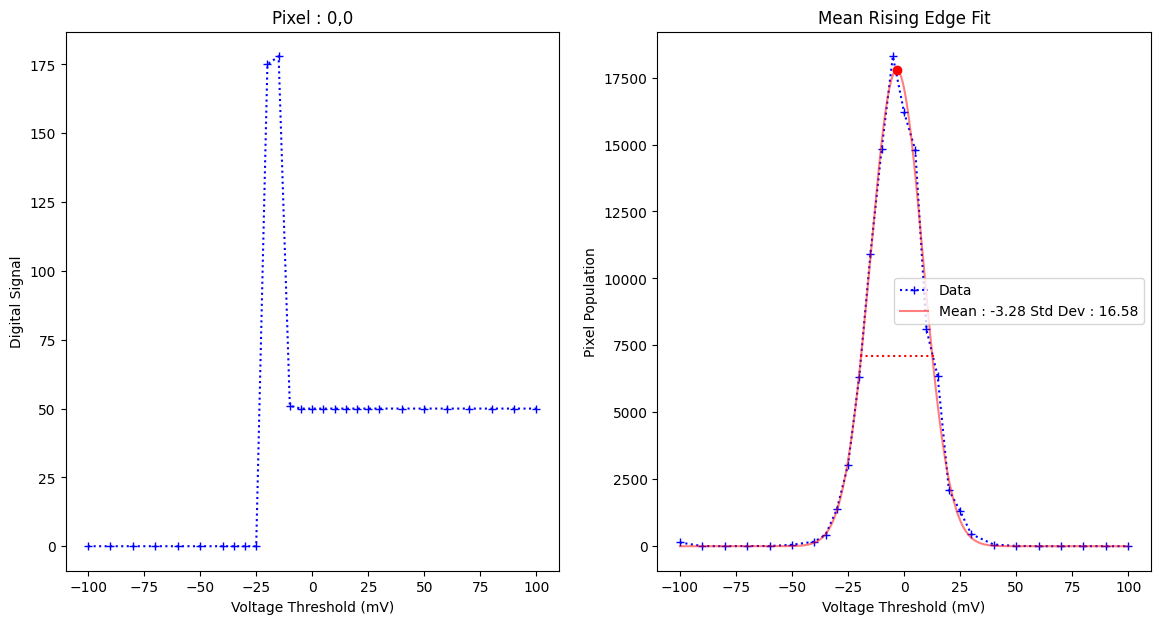

In [14]:
directory = r'C:\Users\chem-chem1612\Documents\PIMMS-Calibration\10-06-24\Static'
static_trim(directory)

Trim: 14, Rising Edge: 0
Trim: 13, Rising Edge: -5
Trim: 12, Rising Edge: -5
Trim: 11, Rising Edge: -5
Trim: 10, Rising Edge: 0
Trim: 9, Rising Edge: -5
Trim: 8, Rising Edge: 0
Trim: 7, Rising Edge: -5
Trim: 6, Rising Edge: 0
Trim: 5, Rising Edge: -10
Trim: 4, Rising Edge: -5


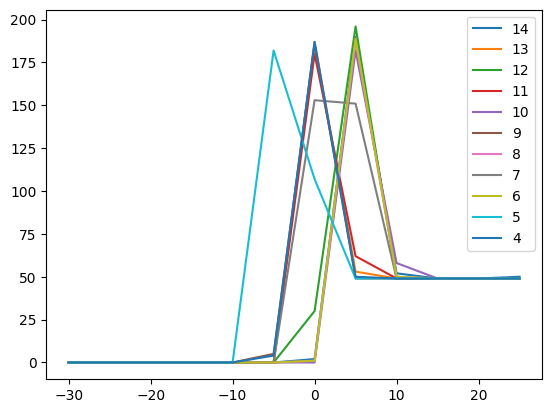

In [9]:
directory = r'C:\Users\chem-chem1612\Documents\PIMMS-Calibration'
thresholds, pixel_means, pixel_means_trims, trim_values = best_trim_value(directory, 445)
mean = -5

for trim_index, trim_value in enumerate(pixel_means_trims[0]):
    x, y = 0, 2
    plt.plot(thresholds,pixel_means[:,trim_index,x,y], label=f'{trim_value}')
    rising_edge = np.where(np.diff(pixel_means[:,trim_index,x,y] > 25))[0]
    if len(rising_edge) == 0: rising_edge = 0
    else: rising_edge = rising_edge[0]
    print(f'Trim: {trim_value}, Rising Edge: {thresholds[rising_edge]}')
plt.legend()

a = np.zeros(419904,)